In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from skimage import data, filters

In [2]:
work_dir = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12'
veloc_fn = f'{work_dir}/mintpy_offsets/velocityRg.h5'
igram_fn = f'{work_dir}/work/merged/interferograms/20200308_20200320/filt_fine.int'
cor_fn = f'{work_dir}/work/merged/interferograms/20200308_20200320/filt_fine.cor'

In [3]:
igram_ds = gdal.Open(igram_fn, gdal.GA_ReadOnly)
igram = igram_ds.GetRasterBand(1).ReadAsArray()

cor_ds = gdal.Open(cor_fn, gdal.GA_ReadOnly)
cor = cor_ds.GetRasterBand(1).ReadAsArray()

In [4]:
ds = xr.open_dataset(veloc_fn)

In [21]:
igram.shape

(7746, 9149)

In [20]:
ds

(1544, 1472)

In [9]:
veloc_filtered = filters.butterworth(ds.velocity.values,
                                     cutoff_frequency_ratio=0.35, #between 0 and 0.5
                                     order=2,
                                     high_pass=False)

In [10]:
# convert to phase for simulated 3 day period
veloc_unwrapped = (veloc_filtered-0.6)*(3/365)*(12.5663706/0.05546576)

In [11]:
veloc_wrapped = np.subtract(np.mod(veloc_unwrapped,2*np.pi), np.pi)

In [12]:
veloc_wrapped

array([[2.0243075, 2.0243056, 2.0243108, ..., 2.0243075, 2.0243084,
        2.0243065],
       [2.0243065, 2.024308 , 2.0243056, ..., 2.0243065, 2.0243065,
        2.0243075],
       [2.0243137, 2.0242984, 2.0243146, ..., 2.024297 , 2.0243142,
        2.024297 ],
       ...,
       [2.0243037, 2.0243123, 2.0242674, ..., 2.0243075, 2.0243037,
        2.0243094],
       [2.0243104, 2.0243065, 2.0243008, ..., 2.0243075, 2.0243084,
        2.0243065],
       [2.0243065, 2.0243113, 2.0243046, ..., 2.024308 , 2.024307 ,
        2.0243084]], dtype=float32)

In [13]:
complex_conjugate_array = np.exp(1j * veloc_wrapped)

In [15]:
igram

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

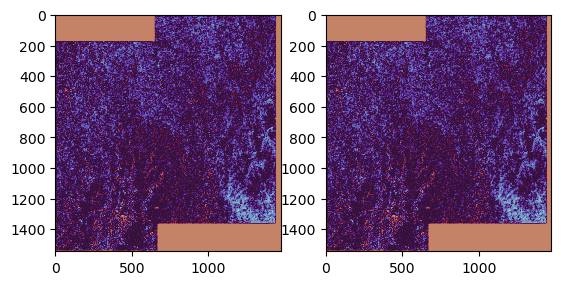

In [16]:
f, ax = plt.subplots(1, 2)
ax[0].imshow(np.angle(complex_conjugate_array), cmap='twilight')
ax[1].imshow(veloc_wrapped, cmap='twilight')